# Logistic Regression

In [55]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [56]:
%store -r final_df
final_df

,Temp,Humidity,Wind,Rain,ISI,Actual Fire
0,8.2,51.0,6.7,0.0,5.1,0.0
1,18.0,33.0,0.9,0.0,6.7,0.0
2,14.6,33.0,1.3,0.0,6.7,0.0
3,8.3,97.0,4.0,0.2,9.0,0.0
4,11.4,99.0,1.8,0.0,9.6,0.0
...,...,...,...,...,...,...
756,30.0,65.0,14.0,0.0,4.5,1.0
757,28.0,87.0,15.0,4.4,0.1,0.0
758,27.0,87.0,29.0,0.5,0.4,0.0
759,24.0,54.0,18.0,0.1,1.7,0.0


## Assumptions
The code below is to verify for logistic regression assumptions. These assumptions include:
- No multicollinearity
- Independence of cases
- Non-Linearity
- No outliers

In [78]:
final_df['Actual Fire'].value_counts()

1.0    407
0.0    353
Name: Actual Fire, dtype: int64

### Outlier Removal

In [79]:
final_df_remove_outliers = final_df[(np.abs(zscore(final_df)) < 3).all(axis=1)]

final_df.index.difference(final_df_remove_outliers.index)

Int64Index([ 11,  22, 266, 499, 519, 608, 609, 610, 621, 622, 633, 640, 655,
            656, 657, 676, 735, 736, 757, 758],
           dtype='int64')

### Normalization

In [120]:
# Normalize columns as to not deal with different units
final_df_remove_outliers = final_df_remove_outliers / final_df_remove_outliers.max()

### Multicollinearity

In [81]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
def create_vif(dataframe):
    ''' This function calculates the Variation Inflation Factors for each column and convert it into a dataframe'''
    
    #create an empty dataframe
    vif_table = pd.DataFrame()
    #populate the first column with the columns of the dataset
    vif_table['variables'] = dataframe.columns
    #calculate the VIF of each column and create a VIF column to store the number
    vif_table['VIF'] = [vif(dataframe.values, i) for i in range(dataframe.shape[1])]
    
    return vif_table

#print the VIF table for each variable
print(create_vif(final_df_remove_outliers))

     variables        VIF
0         Temp  13.033657
1     Humidity   5.554918
2         Wind   6.983634
3         Rain   1.366429
4          ISI   4.581002
5  Actual Fire   2.506154


### Logistic Regression

In [134]:
feature_cols = ['Temp', 'Humidity', 'Wind', 'Rain']
X = final_df_remove_outliers[feature_cols]
Y = final_df_remove_outliers['Actual Fire']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.20, random_state=0)

In [135]:
model = LogisticRegression(solver='liblinear', C=0.05,random_state=0)
model.fit(X_train, Y_train)

LogisticRegression(C=0.05, random_state=0, solver='liblinear')

In [136]:
y_pred = model.predict(X_test)

In [137]:
model.score(X_train, Y_train)

0.5540540540540541

In [138]:
model.score(X_test, Y_test)

0.6081081081081081

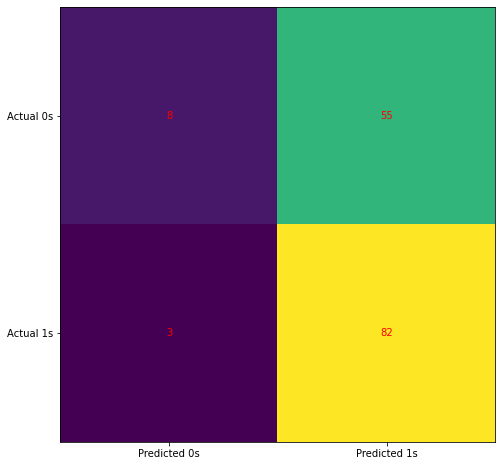

In [139]:
cm = metrics.confusion_matrix(Y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

### Independence

In [140]:
X2 = sm.add_constant(X)

lm1 = sm.OLS(Y,X2)

est = lm1.fit()

C:\Users\Johnny\Documents\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


C:\Users\Johnny\Documents\Anaconda\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


1.0397088595476128e-16

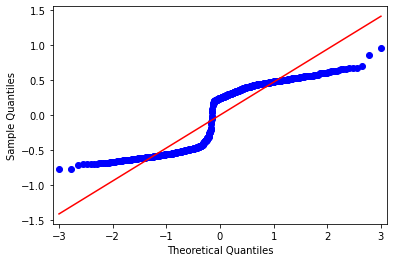

In [141]:
sm.qqplot(est.resid, line= 's')
mean_residuals = sum(est.resid) / len(est.resid)
mean_residuals

By seeing a random pattern from our residuals we can say that we have independent cases from one another.

## Accuracy

In [142]:
print(metrics.classification_report(Y_train, model.predict(X_train)))

              precision    recall  f1-score   support

         0.0       0.67      0.07      0.12       273
         1.0       0.55      0.97      0.70       319

    accuracy                           0.55       592
   macro avg       0.61      0.52      0.41       592
weighted avg       0.60      0.55      0.43       592



In [143]:
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.6081081081081081


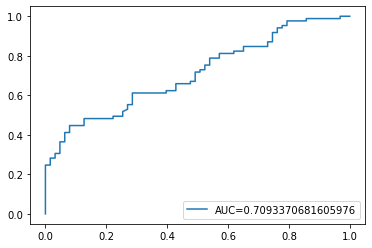

In [144]:
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

## Final Results

From the logistic regression using a machine learning approach we can see that we have decent accuracy but have faith that the accuracy is correct since we verified our assumptions. The next steps are to run the Forest_Fire_Deep_Learning notebook to see if a deep learning approach gives us better results while also applying the linear regression to determine initial spread index.